#LEVIN

Initialize --

The boltzan weights are simple the weights at each size, not between two legs. As a result its a qxqxqxq tensor

RG STEP --

The bond dimension is max(\chi,NxN) where N is the dim of one of the legs (all are the same) 

Tensor is transformed to 2Nx2N matrices of both!! bottom and left (yielding S1 & S3) and right and bottom (yielding S2 and S4)

Normal SVD is being done on both cases, where the square root of truncated eigvanlues is being added in both sides

The respective SVD's are done on alternating lattices. Four of these S's are then contracted with each other. 
yielding a RG step of 1/2^i

The normalization factos are also kept, and additionally is divided by change in length 2^steps each time (these are partition function)

Analysis --

CFT data is explicitely take from REAL part of eigenvalues, also assumed periodic boundart conditions

#### Loop optimatition for Tensor Network Renormalization

-- intialization

same input as levin

--RG Step

" employing a larger unit-cell for optimization processes and effectively
filtering out local entanglement"

-Projection

does a levin SVD on 4 tensors at the same time, yielding a ring of 8 S tensors. These will be approximated and the levin will serve as starting point. It minizes through a cost function, minimizing the norm of the intial tensors and the S's

-Entanglement filtering
using a QR matrix decomposition (A = N1 x N2 into Q = N1 x N2 and P = N2 x N2, where Q isometric, R upper triangle) we can limit the transfer matrix space to be restricted to largest eigenvalue subspace. We do this by imputing identity rank N matrix L and letting it loop around the T tensors by ways of QR decomposition (L1 T1 = \alt(T1) \alt(L2)), until L is converged (proportional to diag(1,0,0..)) which is then the Left projector. We do the same for a right one startig from T4 and going to T3,.. . SVD the product of L R those yields us projectors. P1L, P4R. We can start at any point and yield PiL,Pi+1R. These must be placed in between i and i+1.


-- Implementation 
1. Entanglement filter Ta and Tb
2. Improve the tensors individually by solving N T = W. 
3. After every round of 8 (each S determined) calculated the cost function and see if it is under tolerance
4. If yes, normalize.


In [68]:
# import necessary modules
## run in global enviroment
import numpy as np
from tqdm import tqdm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Initialization.py includes various lattice models. Feel free to play with other models!
from Initialization import initialize_Potts
import loop_opt as tnr
import cft

In [101]:
data=[]
norm_list=[]
D_list=np.array([4,8,12,16,20])
for D in D_list:
    data.append(np.real(np.load("tnr_data_pottsq5/Critical_{}.npy".format(D),allow_pickle=True)))
    norm_list.append(np.real(np.load("tnr_data_pottsq5/norm_{}.npy".format(D),allow_pickle=True))) 
cstart=2

In [102]:
### Stores the norms for all D's
## I would think the last one is the most interesting
lnz=np.zeros((len(D_list), len(norm_list[0])))
for i in range(len(D_list)):
    #T
    temp=0
    area=4
    #N
    for j in range(len(norm_list[0])):
        temp+=np.log(np.real(norm_list[i][j]))/area
        lnz[i,j]=temp
        area*=2
lnZ=np.zeros((len(D_list),len(norm_list[0])))
for i in range(len(norm_list[0])):
    lnZ[:,i]=lnz[:,i]*2**(i+2)

### data[0]->central charge, data[n]->scaling dimension of four first fields for a D
lnlambda0=np.zeros((len(D_list),len(data[0])))
for i in range(len(D_list)):
    for j in range(len(data[0])):
        # ln(c) = ln(Λ_0)*6/ pi　（see cft.py)
        lnlambda0[i,j]=np.pi*data[i][j][0]/6+np.log(np.real(norm_list[i][j+1]))
lE0_list=np.zeros((len(D_list),len(data[0])))
for i in range(len(D_list)):
    for j in range(len(data[0])):
        lE0_list[i,j]=-(lnlambda0[i,j]+lnZ[i,j+1])
print(np.shape(lE0_list))

(5, 30)


(0.0, 70000.0)

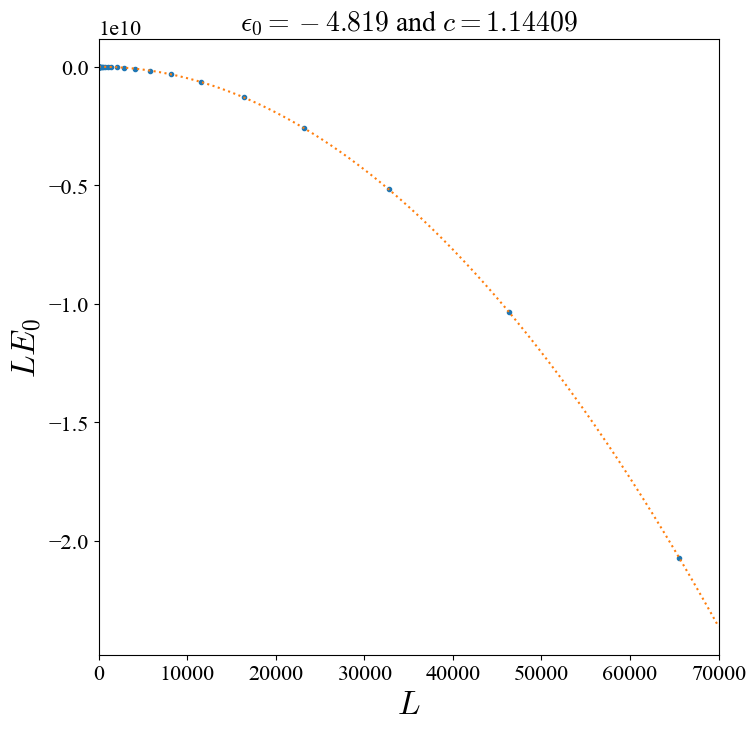

In [103]:
def parabola_fit(x,a,b):
    return a*x**2+b
l_list=2**(np.linspace(1.5,1+0.5*len(data[0]),len(data[0])))
fd,cov=curve_fit(parabola_fit,l_list[1:8],lE0_list[-1,1:8])
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams["font.family"] = "Times New Roman"

plt.figure(figsize=(8,8))
plt.plot(l_list,lE0_list[-1],".")
plt.plot(np.linspace(0,7e4,1000),parabola_fit(np.linspace(0,7e4,1000),fd[0],1),":",label="Fit")
plt.title(r"$\epsilon_0={0}$ and $c={1}$".format(np.round(fd[0],3),np.round(-fd[1]*6/np.pi,5)),fontsize=20)
plt.ylabel(r"$LE_0$",fontsize=24)
plt.xlabel(r"$L$",fontsize=24)
plt.xlim(0,7e4)

[ 4  8 12 16 20]


C:\Users\vicva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:16: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


Text(0, 0.5, '$L^2\\delta x$')

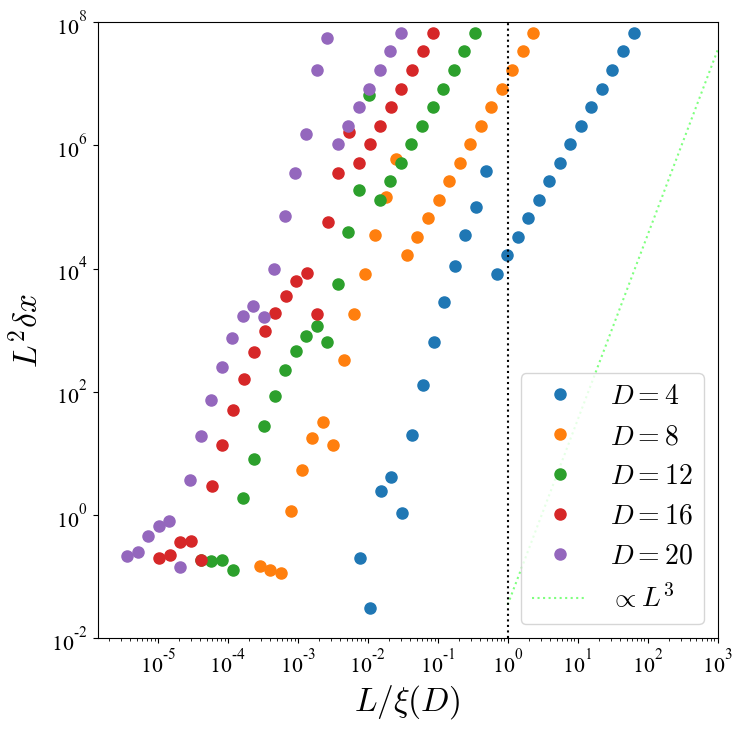

In [104]:
### As expected, the energy gaps does not follow the correlation length scaling anymore
kappa_exp=6/(1.14409*(1+np.sqrt(1.14409/12)))
kappa_th = 6/(1.13755*(1+np.sqrt(1.13755/12)))
kappa_compl = np.abs(6/((1.13755+0.210678j)*(1+np.sqrt(1.13755+0.210678j)/12)))
gap_list=np.zeros((len(D_list),len(data[0])))
for i in range(len(D_list)):
    gap_list[i] = data[i][:,1]
delta_sigma = gap_list - 1/8
plt.figure(figsize=(8,8))
print(D_list)
for i in range(5):
    plt.plot(l_list/(0.5*D_list[i]**kappa_compl),abs(gap_list[i])*l_list**2,".",label="$D={}$".format(D_list[i]),markersize=16)
plt.plot(np.linspace(1,1000,1000),0.035*np.linspace(1,1000,1000)**3,":",color="lime",alpha=0.5,label="$\propto L^3$")
plt.xscale("log")
plt.yscale("log")
plt.xlim(-1,1e3)
plt.ylim(1e-2,1e8)
plt.axvline(1.,linestyle=":",color="black")
plt.legend(loc="lower right",fontsize=20)
plt.xlabel(r'$L/\xi(D)$',fontsize=24)
plt.ylabel("$L^2 x$",fontsize=24)

### As a result, it makes more sense that the central coefficient of the Entropy scaling MPS is wrong. This one makes more sense.

Text(0, 0.5, '$x_\\sigma$')

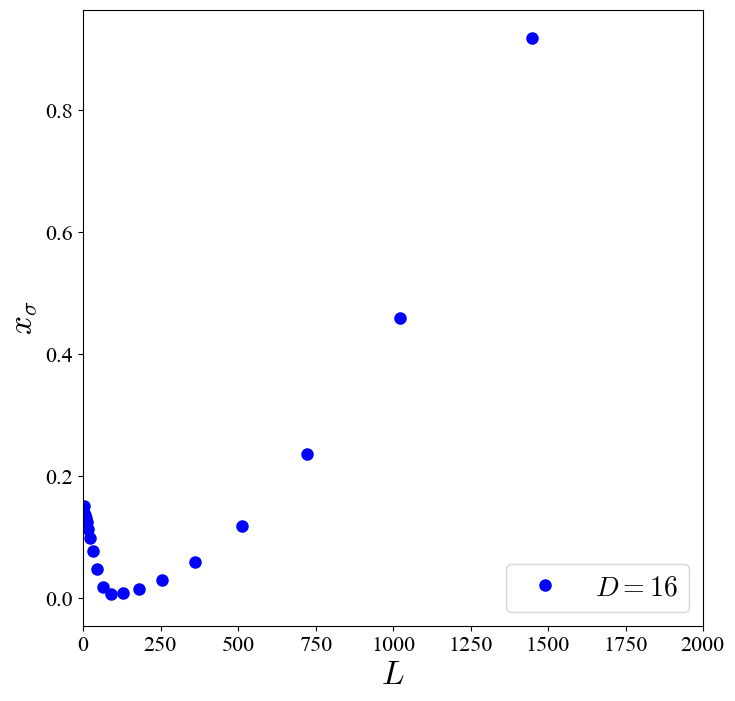

In [108]:
### There do seem to be regions of the scaling, where the dependecies change (like in Ising)
### for large L its stuck at some initial value, for lower L it does some function, convering to a value -> not a given thats its converged
plt.figure(figsize=(8,8))
i=3
plt.plot(l_list,(gap_list[i]),".",markersize=16,color="blue",label="$D={}$".format(D_list[i]))
plt.xlim(0,2000)
plt.legend(loc="lower right",fontsize=20)
plt.xlabel("$L$",fontsize=24)
plt.ylabel("$x_\sigma$",fontsize=24)

Text(0, 0.5, '$x_\\sigma$')

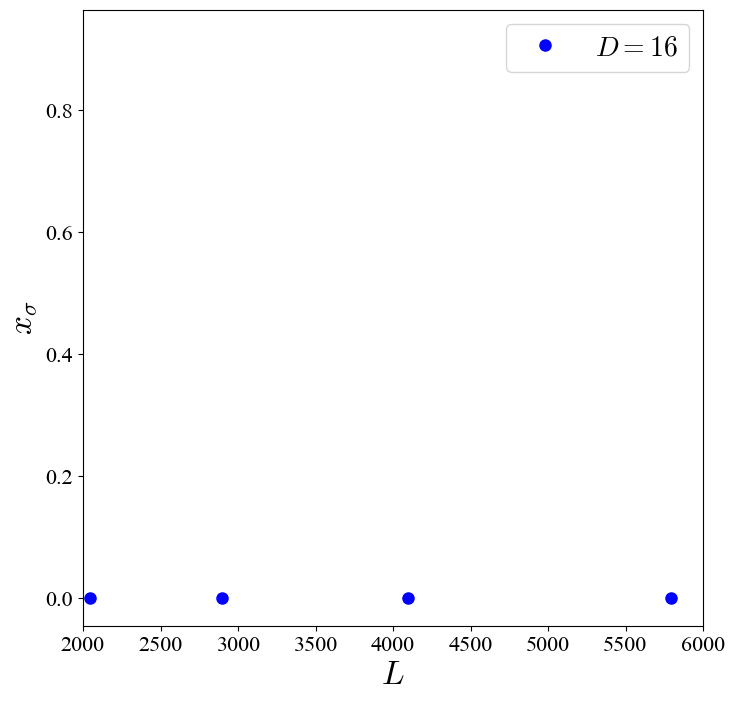

In [109]:

plt.figure(figsize=(8,8))
i=3
plt.plot(l_list,(gap_list[i]),".",markersize=16,color="blue",label="$D={}$".format(D_list[i]))
plt.xlim(2000,6000)
plt.legend(loc="upper right",fontsize=20)
plt.xlabel("$L$",fontsize=24)
plt.ylabel("$x_\sigma$",fontsize=24)

Text(0, 0.5, 'x_\\sigma$')

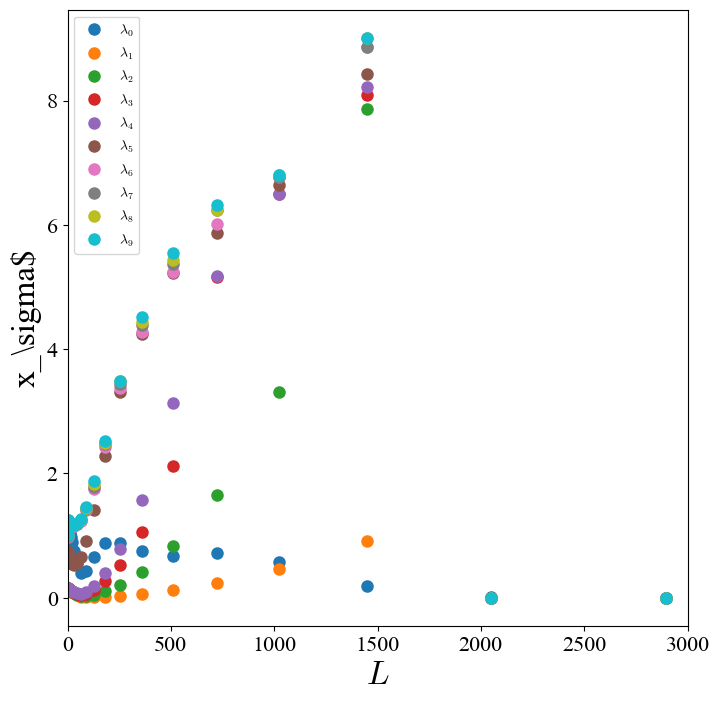

In [111]:
plt.figure(figsize=(8,8))
gap_list=np.zeros((10,len(data[0])))
for j in range(0,10):
    gap_list[j] = data[3][:,j]
    ### for large L its stuck at some initial value, for lower L it does some function, convering to a value -> not a given thats its converged
    
    plt.plot(l_list,(gap_list[j]),".",markersize=16,label="$\lambda_{}$".format(range(10)[j]))
plt.xlim(0,3000)
plt.legend(loc="upper left",fontsize=10)
plt.xlabel("$L$",fontsize=24)
plt.ylabel("x_\sigma$",fontsize=24)


In [112]:
Tc = 1/np.log(1+np.sqrt(5))
def collect_Potts_off(T, d_cut, size):
    keep_num_scaling = d_cut ** 2
    error_limit = 1.0E-14
    maxloop = 80
    area = 4.

    cft_result = np.zeros((size, keep_num_scaling))
    norm_list = []

    tA = initialize_Potts(5,T)
    tB = np.copy(tA)

    tA, tB, norm = tnr.normalize_tensor(tA, tB)
    norm_list.append(norm)
    ln_z = np.log(norm)/area

    for i in tqdm(range(size)):
        tA, tB, norm = tnr.TNR_step(tA,tB,d_cut,error_limit,maxloop)
        area *= 2
        ln_z += np.log(norm) / area
        norm_list.append(norm)
        data = cft.cal_sdimension(tA, tB, norm)
        cft_result[i, 0:min(keep_num_scaling, np.shape(data)[0])] = data[0:min(keep_num_scaling, np.shape(data)[0])]
    if T > Tc:
        np.save("tnr_data_pottsq5/high_{}.npy".format(d_cut), cft_result)
        np.save("tnr_data_pottsq5/high_norm_{}.npy".format(d_cut), norm_list)
    elif T < Tc:
        np.save("tnr_data_pottsq5/low_{}.npy".format(d_cut), cft_result)
        np.save("tnr_data_pottsq5/low_norm_{}.npy".format(d_cut), norm_list)

In [71]:
# Again, you can compute, or just use the data from /tnr_data
#collect_Potts_off(Tc*(1+1e-4),16,28)
#collect_Potts_off(Tc*(1-1e-4),16,28)

100%|██████████| 28/28 [1:08:08<00:00, 146.01s/it]


In [113]:
# Load data from /tnr_data
data=[]
data.append(np.real(np.load("tnr_data_pottsq5/high_16.npy",allow_pickle=True)))
data.append(np.real(np.load("tnr_data_pottsq5/low_16.npy",allow_pickle=True)))
cstart=2
LABEL=["$g_t(T>T_c)$","$g_t (T<T_c)$"]
print(np.shape(data))

(2, 28, 256)


Text(0, 0.5, '$x_\\sigma$ + $x_\\epsilon$/16')

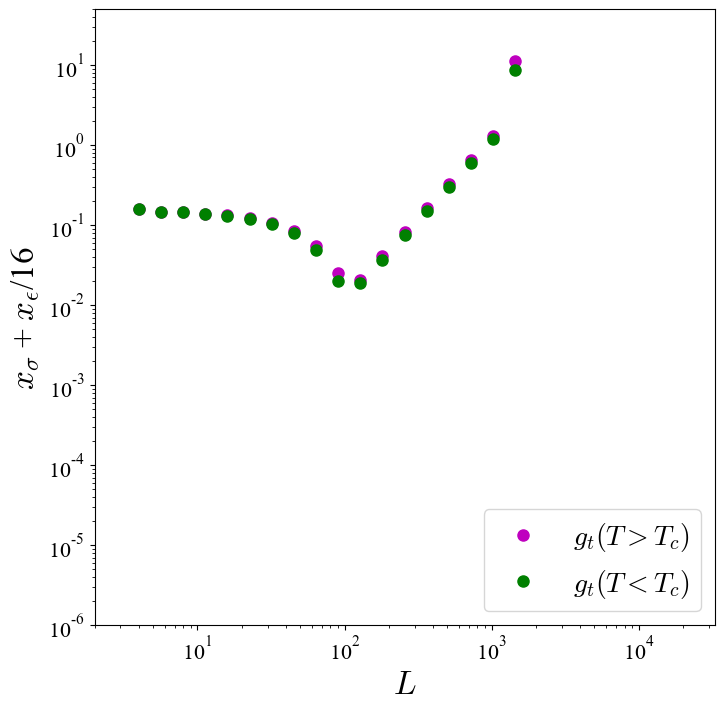

In [119]:
gap_list=np.zeros((4,24))
gap_list2=np.zeros((4,24))
l_list=2**(np.linspace(1.5,13,24))

for i in range(2): ### Gets the first and the second energy levels of the Rg steps resp gap_list 1 and 2
    gap_list[i]=data[i][:24,1]
    gap_list2[i]=data[i][:24,2]
color_list= ["m", "g", "r", "b", "y", "k", "w"]
plt.figure(figsize=(8,8))
for i in range(2):
    if i >=2:
        plt.plot(l_list,((gap_list[i])+(gap_list2[i])/16),".",markersize=16,color=color_list[i],label=LABEL[i])
        plt.plot(l_list,-((gap_list[i])+(gap_list2[i])/16),"+",markersize=16,color=color_list[i])
    else:
        plt.plot(np.sqrt(2)*l_list,((gap_list[i])+(gap_list2[i])/16),".",markersize=16,color=color_list[i],label=LABEL[i])
        plt.plot(np.sqrt(2)*l_list,-((gap_list[i])+(gap_list2[i])/16),"+",markersize=16,color=color_list[i])
#plt.plot(l_list[12:80],8.5e-12*l_list[12:80]**3.75,":",label="$\propto L^{15/4}$")
plt.xscale("log")
plt.yscale("log")
plt.xlim(2,l_list[-1]*4)
plt.ylim(1e-6,50)
plt.legend(loc="lower right",fontsize=20)
plt.xlabel("$L$",fontsize=24)
plt.ylabel("$x_\sigma$ + $x_\epsilon$/16",fontsize=24)


In [120]:
nn=5
t_list=((gap_list[0,nn:])+(gap_list2[2,nn:])/16)
t_list2=((gap_list[1,nn:])+(gap_list2[3,nn:])/16)
h_list=np.sqrt(np.abs((gap_list[0,nn:])+(gap_list2[0,nn:])/16))
h_list2=-np.sqrt(np.abs((gap_list[1,nn:])+(gap_list2[1,nn:])/16))

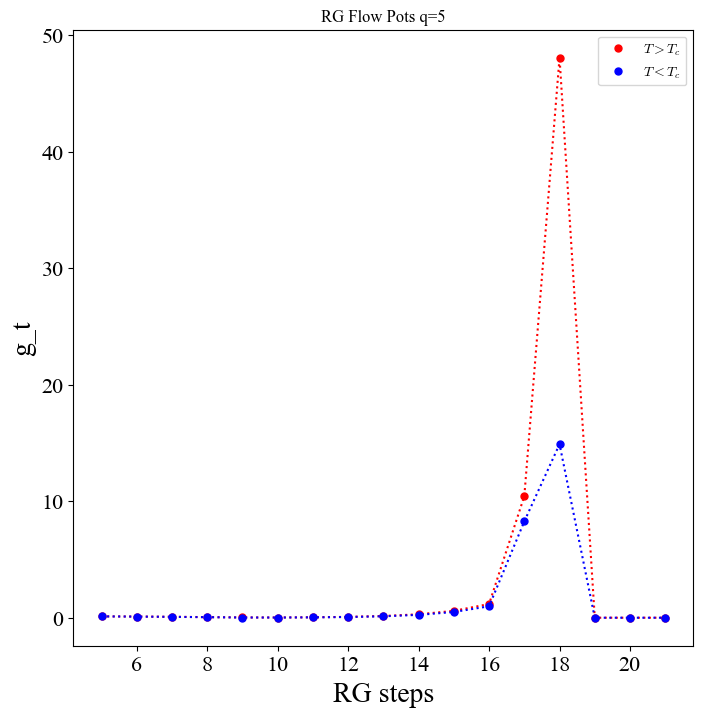

In [121]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
ax.plot(np.arange(5,22),t_list[:-2],".",color=color_list[2],markersize=10,label="$T>T_c$")
ax.plot(np.arange(5,22),t_list[:-2],":",color=color_list[2])
ax.plot(np.arange(5,22),t_list2[:-2],".",color=color_list[3],markersize=10,label="$T<T_c$")
ax.plot(np.arange(5,22),t_list2[:-2],":",color=color_list[3])
plt.ylabel('g_t',size=20)
plt.xlabel('RG steps',size=20)
plt.title('RG Flow Pots q=5')
#### There is some artefact that everything is zero at the end (maybe it becomes zero because number is too high?)7
## However, you see clearly that both blow up late (and thats what you want because there is no fix point)
### aditionally, its nice to see that the T<Tc blow ups later since that one starts from farther
plt.legend()